<a href="https://colab.research.google.com/github/davidolima/car-model-classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho final - Curso Deep Learning
### Prof. Luciano de Rebouças
### Aluno: David de Oliveira Lima

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install tensorflow_ranking scikit-learn;

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


# Imports

In [ ]:
# Core
import tensorflow as tf
import tensorflow.keras as keras

# Redes e optimizers
from keras.applications import VGG19, ResNet50V2 #, EfficientNetB0, InceptionV3
from keras.optimizers import Adam, SGD

# Keras
from keras import Sequential
from keras.utils import to_categorical, image_dataset_from_directory, split_dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
import keras.metrics

#tfr
import tensorflow_ranking as tfr

# Etc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from sklearn.model_selection import KFold
from tensorflow_datasets import as_numpy
from sklearn.utils import shuffle
from PIL import Image
from sklearn.metrics import classification_report

# Parâmetros

In [ ]:
n_classes = 196
epochs = 50
batch_size = 64
n_folds = 3
img_size = (224,224)
es_patience = 8
root = "/content/drive/MyDrive/Colab Notebooks/car196/"
val_split = 0.2
channels = 3

# Inicialização

## Funções auxiliares



In [ ]:
# Funções para gráficos
def plotMetrics(hist):
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['val_precision_m'])
    plt.plot(hist.history['val_recall_m'])
    plt.plot(hist.history['val_f1_m'])
    plt.ylabel('metrics')
    plt.xlabel('epoch')
    plt.legend(['Accuracy', 'Precision', 'Recall', 'F1_score'], loc='lower right')
    plt.show()

def plotHist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plotPR(hist):
    plt.plot(hist.history['recall_m'],hist.history['precision_m'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

def plotFoldsMetrics(hists):
  """
  Plotar métricas para três folds
  """
  for i in range(1,4):
    plt.subplot(3,1,i)
    plt.title(f'Fold {i} - Metrics')
    plotMetrics(hists[i-1])
  plt.show()

def plotFoldsHists(hists):
  """
  Plotar acuracia de treino e validação para três folds
  """
  for i in range(1,4):
    plt.subplot(3,1,i)
    plt.title(f'Fold {i} - Model accuracy')
    plotHist(hists[i-1])
  plt.show()

def plotFoldsPR(hists):
  """
  Plotar Precision x Recall para três folds
  """
  for i in range(1,4):
    plt.subplot(3,1,i)
    plt.title(f'Fold {i} - Precision x Recall')
    plotPR(hists[i-1])
  plt.show()

In [ ]:
# Função para carregamento de dados
def carregarDados(dir:str, resize_shape:tuple=None, shuffle_data:bool=True, seed:int=None, return_map:bool=False):
  """
  !!! AVISO: ESSA FUNÇÃO CARREGA TODO O DATA SET NA MEMÓRIA !!!
  Função para criar um data set a partir de uma pasta com labels em sua estrutura.
  Apesar de modular, esta função foi feita para o carragemento do dataset cars196,
  que tem como estrutura:
  cars196:
     - train
        - classe 1
        ...
        - classe 196
     - test
        ...
        - classe 196
  Retorna a tupla (inputs, labels), onde inputs e labels são listas.
  """

  inputs, labels = [], []
  label_map = {}
  classes = []

  root = dir
  dir = os.listdir(root)

  for f in dir:
    if os.path.isdir(root + f):
      classes.append(f)

  print(f"{len(classes)} classes encontradas.")

  # codificar classes em números
  for i, classe in enumerate(classes):
    label_map[classe] = i

  # extrair imagens de cada classe com suas respectivas labels
  for classe in classes:
    for image in os.listdir(root + classe):
      image = Image.open(root+classe+"/"+image)

      # Redimensionar
      if resize_shape:
        image = image.resize(resize_shape)

      inputs.append(np.array(image))
      labels.append(label_map[classe])

  print(f"{len(inputs)} imagens carregadas.")

  # Embaralhar dados
  if shuffle_data:
    inputs, labels = shuffle(inputs, labels, random_state=(None if not seed else seed))

  #inputs, labels = np.asarray(inputs,dtype=np.int8), np.asarray(labels,dtype=np.uint8)
  if not return_map:
    return (inputs, labels)
  return (inputs, labels), label_map

In [ ]:
def decodeLabel(i:int, label_map:dict) -> str:
  return list(label_map.keys())[list(i).index(1)]

## Métricas

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Carregamento de dados

In [ ]:
# Carregar dataset
print("Training images: ",end='')
(x_train, y_train), label_map = carregarDados(root + 'train/',resize_shape=img_size,return_map=True)
y_train = to_categorical(y_train)

Training images: 196 classes encontradas.
8144 imagens carregadas.


In [ ]:
print("Test images: ",end='')
ds_test = image_dataset_from_directory(
    root + "test/",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
)

Test images: Found 8041 files belonging to 196 classes.


In [ ]:
x_train = np.asarray(list(map(np.asarray,x_train)))
y_train = np.asarray(list(map(np.asarray,y_train)))

Mercedes-Benz Sprinter Van 2012


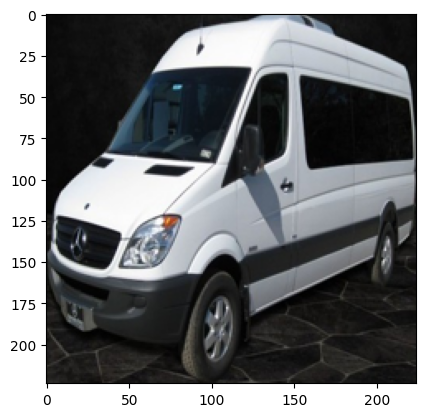

In [ ]:
# Testar x_train e y_train
from matplotlib.pyplot import imshow

i = np.random.randint(len(x_train))
print(decodeLabel(y_train[i], label_map))
imshow(x_train[i])

In [ ]:
# RODAR APENAS DURANTE A AVALIAÇÃO DO BEST MODEL OU SE O DATA SET DE TREINO NÃO ESTIVE CARREGADO!
# OS DOIS DATA SETS NA MEMÓRIA OCUPA MUITO ESPAÇO
x_test, y_test = carregarDados(root + 'test/',resize_shape=img_size)
y_test = to_categorical(y_test)
x_test = np.asarray(list(map(np.asarray,x_test)))
y_test = np.asarray(list(map(np.asarray,y_test)))

## Augmentation

In [ ]:
# Augmentation
resize_and_rescale = tf.keras.Sequential([
  Resizing(img_size[0], img_size[1]),
  Rescaling(1./255)
])

augmentation = keras.Sequential([
    # Resizing(img_size[0],img_size[1]),
    # Rescaling(1./255),
    RandomRotation(0.30),
    RandomFlip("horizontal"),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Treinamento das redes

## VGG19

### Inicialização

In [ ]:
adam = Adam(.001,
           beta_1=0.9,
           beta_2=0.999,
           )

sgd = SGD(
    5e-3,
    momentum=.9
)
criterion = categorical_crossentropy
early_stop = EarlyStopping(monitor='val_f1_m',
                           mode='max', verbose=1,
                           patience=es_patience,
                           restore_best_weights = True
                           )

In [ ]:
base = VGG19(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

for l in base.layers:
  l.trainable = False

# model_1.build((None, img_size[0], img_size[1], channels))
# model_1.summary()

80134624/80134624 [==============================] - 0s 0us/step


### Treinamento

In [ ]:
# Training
kfold = KFold(n_splits=n_folds, shuffle=True)

fold_no = 1
fold_histories = []

for train, validation in kfold.split(x_train, y_train):
  checkpoint = ModelCheckpoint(f"/content/trab-final-best-vgg-{fold_no}.hdf5",
                                monitor='val_f1_m', verbose=1,
                                save_best_only=True,
                                mode='max')

  model_1 = Sequential([
    resize_and_rescale,
    augmentation,
    base,
    Flatten(),
    Dense(n_classes, activation='softmax'),
  ])

  model_1.compile(loss=criterion,
                optimizer=sgd,
                metrics=["accuracy",
                        recall_m,
                        precision_m,
                        f1_m,
                        tfr.keras.metrics.MeanAveragePrecisionMetric()],
                )

  print('------------------------------------------------------------------------')
  print('> Fold', fold_no)
  history = model_1.fit(x_train[train], y_train[train],
                        validation_data=(x_train[validation],y_train[validation]),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[keras.callbacks.History(), early_stop, checkpoint])


  fold_histories.append(history)

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
> Fold 1
Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 7.0795 - accuracy: 0.0074 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - mean_average_precision_metric: 0.0368
Epoch 1: val_f1_m improved from -inf to 0.00000, saving model to /content/trab-final-best-vgg-1.hdf5
85/85 [==============================] - 75s 659ms/step - loss: 7.0795 - accuracy: 0.0074 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - mean_average_precision_metric: 0.0368 - val_loss: 7.3512 - val_accuracy: 0.0140 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_mean_average_precision_metric: 0.0498
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 7.1764 - accuracy: 0.0254 - recall_m: 3.6765e-04 - precision_m: 0.0235 - f1_m: 7.2398e-04 - mean_average_precision_metric: 0.0677
Epoch 2: val_f1_m improved from 0.00000 to 0.00499, s

### Avaliação de resultados

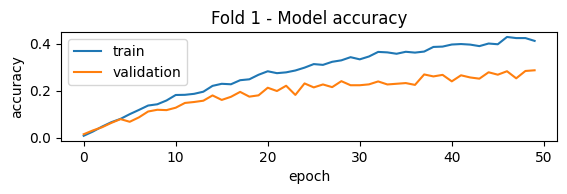

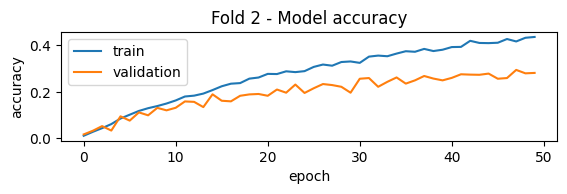

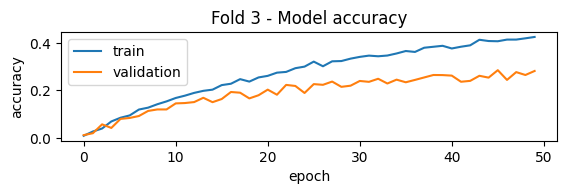

In [ ]:
plotFoldsHists(fold_histories)

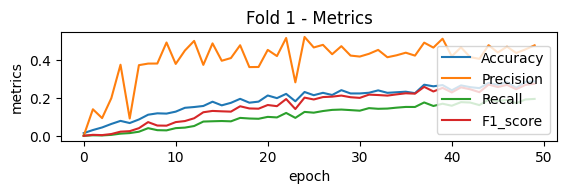

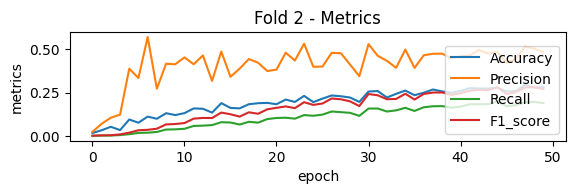

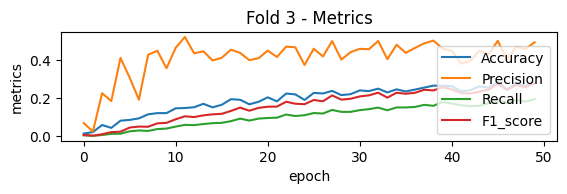

In [ ]:
plotFoldsMetrics(fold_histories)

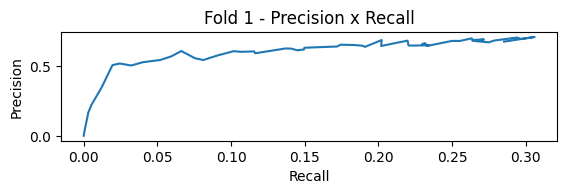

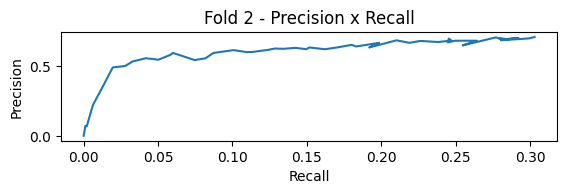

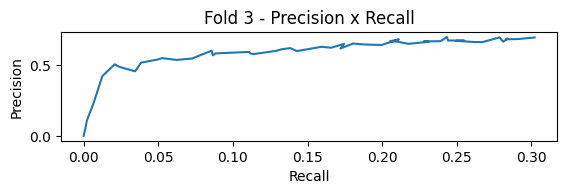

In [ ]:
plotFoldsPR(fold_histories)

In [ ]:
# Salvar Históricos
import pickle
for i in range(len(fold_histories)):
  with open(f'/content/vgg-19-history-fold-{i+1}.pickle', 'wb') as f:
    pickle.dump(fold_histories[i].history, f)

### Escolha do best model

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/results/trab-final-best-vgg-{}.hdf5"
model_f1 = keras.models.load_model(path.format(1),
                                    custom_objects={"recall_m": recall_m,
                                                    "precision_m": precision_m,
                                                    "f1_m": f1_m})
model_f2 = keras.models.load_model(path.format(2),
                                    custom_objects={"recall_m": recall_m,
                                                    "precision_m": precision_m,
                                                    "f1_m": f1_m})
# model_f3 = keras.models.load_model(path.format(3),
#                                    custom_objects={"recall_m": recall_m,
#                                                    "precision_m": precision_m,
#                                                    "f1_m": f1_m})

In [ ]:
# Avaliação do best model do fold 1
m1_evaluation = model_f1.evaluate(ds_test, batch_size=batch_size)
# Avaliação do best model do fold 2
m2_evaluation = model_f2.evaluate(ds_test, batch_size=batch_size)
# Avaliação do best model do fold 3
m3_evaluation = model_1.evaluate(ds_test, batch_size=batch_size)

126/126 [==============================] - 41s 307ms/step - loss: 3.9700 - accuracy: 0.2916 - recall_m: 0.2057 - precision_m: 0.4945 - f1_m: 0.2890 - mean_average_precision_metric_2: 0.4046


In [ ]:
print("Model  |  Loss  | Accuracy | Recall | Precision | F1-Score | mAP")
print("Fold 1 | {:.3f} |  {:.3f}   | {:.3f}  |   {:.3f}   |  {:.3f}   | {:.3f}".format(m1_evaluation[0],m1_evaluation[1],m1_evaluation[2],m1_evaluation[3],m1_evaluation[4],m1_evaluation[5]))
print("Fold 2 | {:.3f} |  {:.3f}   | {:.3f}  |   {:.3f}   |  {:.3f}   | {:.3f}".format(m2_evaluation[0],m2_evaluation[1],m2_evaluation[2],m2_evaluation[3],m2_evaluation[4],m2_evaluation[5]))
print("Fold 3 | {:.3f} |  {:.3f}   | {:.3f}  |   {:.3f}   |  {:.3f}   | {:.3f}".format(m3_evaluation[0],m3_evaluation[1],m3_evaluation[2],m3_evaluation[3],m3_evaluation[4],m3_evaluation[5]))

Model  |  Loss  | Accuracy | Recall | Precision | F1-Score | mAP
Fold 1 | 3.936 |  0.295   | 0.200  |   0.511   |  0.286   | 0.405
Fold 2 | 3.819 |  0.287   | 0.194  |   0.481   |  0.275   | 0.402
Fold 3 | 3.970 |  0.292   | 0.206  |   0.494   |  0.289   | 0.405


### Avaliação do best model

In [47]:
# Carregar best model (Fold 3)
# Best model escolhido levando em consideração seu f1-score e acurácia.
bm_path = "/content/drive/MyDrive/Colab Notebooks/results/trab-final-best-vgg-3.hdf5"
best_model = keras.models.load_model(bm_path,
                                    custom_objects={"recall_m": recall_m,
                                                    "precision_m": precision_m,
                                                    "f1_m": f1_m})

In [48]:
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 196)               4917444   
                                                                 
Total params: 24,941,828
Trainable params: 4,917,444
Non-trainable params: 20,024,384
_________________________________________________________________


In [49]:
bm_evaluation = best_model.predict(ds_test,
                                   batch_size=batch_size,
                                   callbacks=[keras.callbacks.History()])

126/126 [==============================] - 47s 363ms/step


In [50]:
print(classification_report(np.argmax(bm_prediction,axis=1), np.argmax(y_test,axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        29
           4       0.02      0.08      0.04        12
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00        29
          10       0.00      0.00      0.00       132
          11       0.00      0.00      0.00        47
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        26
          16       0.00      0.00      0.00         5
          17       0.03    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
bm_hist = best_model.fit(ds_test,
                         epochs=10,
                          batch_size=batch_size,
                          callbacks=[keras.callbacks.History()])

Epoch 1/10
126/126 [==============================] - 53s 370ms/step - loss: 4.7443 - accuracy: 0.2267 - recall_m: 0.1407 - precision_m: 0.4121 - f1_m: 0.2086 - mean_average_precision_metric_2: 0.3293
Epoch 2/10
126/126 [==============================] - 48s 364ms/step - loss: 4.6875 - accuracy: 0.2215 - recall_m: 0.1368 - precision_m: 0.3946 - f1_m: 0.2020 - mean_average_precision_metric_2: 0.3315
Epoch 3/10
126/126 [==============================] - 46s 352ms/step - loss: 4.6443 - accuracy: 0.2411 - recall_m: 0.1578 - precision_m: 0.4386 - f1_m: 0.2312 - mean_average_precision_metric_2: 0.3466
Epoch 4/10
126/126 [==============================] - 46s 353ms/step - loss: 4.4542 - accuracy: 0.2528 - recall_m: 0.1646 - precision_m: 0.4598 - f1_m: 0.2410 - mean_average_precision_metric_2: 0.3588
Epoch 5/10
126/126 [==============================] - 45s 348ms/step - loss: 4.3279 - accuracy: 0.2609 - recall_m: 0.1720 - precision_m: 0.4802 - f1_m: 0.2517 - mean_average_precision_metric_2: 0.

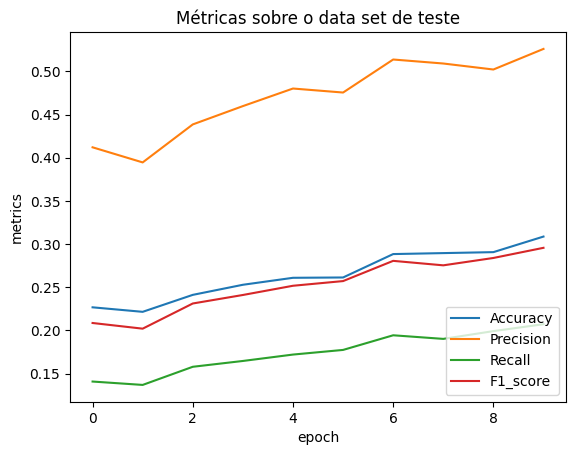

In [52]:
plt.plot(bm_hist.history['accuracy'])
plt.plot(bm_hist.history['precision_m'])
plt.plot(bm_hist.history['recall_m'])
plt.plot(bm_hist.history['f1_m'])
plt.title("Métricas sobre o data set de teste")
plt.ylabel('metrics')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1_score'], loc='lower right')
plt.show()

## ResNet50V2

### Inicialização

In [ ]:
adam = Adam(.001,
           beta_1=0.9,
           beta_2=0.999,
           )

sgd = SGD(
    5e-3,
    momentum=.9
)
criterion = categorical_crossentropy
early_stop = EarlyStopping(monitor='val_f1_m',
                           mode='max', verbose=1,
                           patience=es_patience,
                           restore_best_weights = True
                           )

In [ ]:
base = ResNet50V2(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

for l in base.layers:
  l.trainable = False

### Treinamento

In [ ]:
  # Training
  kfold = KFold(n_splits=n_folds, shuffle=True)

  fold_no = 1
  fold_histories = []

  for train, validation in kfold.split(x_train, y_train):
    checkpoint = ModelCheckpoint(f"/content/trab-final-best-resnet-{fold_no}.hdf5",
                                  monitor='val_f1_m', verbose=1,
                                  save_best_only=True,
                                  mode='max')

    model_2 = Sequential([
        resize_and_rescale,
        augmentation,
        base,
        Flatten(),
        Dense(n_classes, activation='softmax'),
    ])

    model_2.compile(loss=criterion,
                  optimizer=sgd,
                  metrics=["accuracy",
                            recall_m,
                            precision_m,
                            f1_m,
                            tfr.keras.metrics.MeanAveragePrecisionMetric()],
                  )

    print('------------------------------------------------------------------------')
    print('> Fold', fold_no)
    history = model_2.fit(x_train[train], y_train[train],
                          validation_data=(x_train[validation],y_train[validation]),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          callbacks=[keras.callbacks.History(), early_stop, checkpoint])


    fold_histories.append(history)

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
> Fold 1
Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 90.2438 - accuracy: 0.0457 - recall_m: 0.0452 - precision_m: 0.0460 - f1_m: 0.0456 - mean_average_precision_metric_5: 0.0959
Epoch 1: val_f1_m improved from -inf to 0.06298, saving model to /content/trab-final-best-resnet-1.hdf5
85/85 [==============================] - 43s 459ms/step - loss: 90.2438 - accuracy: 0.0457 - recall_m: 0.0452 - precision_m: 0.0460 - f1_m: 0.0456 - mean_average_precision_metric_5: 0.0959 - val_loss: 96.9342 - val_accuracy: 0.0637 - val_recall_m: 0.0629 - val_precision_m: 0.0631 - val_f1_m: 0.0630 - val_mean_average_precision_metric_5: 0.1301
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 79.0955 - accuracy: 0.1253 - recall_m: 0.1252 - precision_m: 0.1256 - f1_m: 0.1254 - mean_average_precision_metric_5: 0.2089
Epoch 2: val_f1_m improved from 0.06298 to 0.11717, saving model to /content/trab-

### Avaliação de resultados

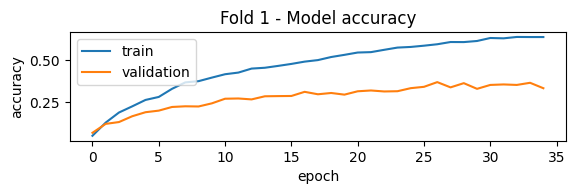

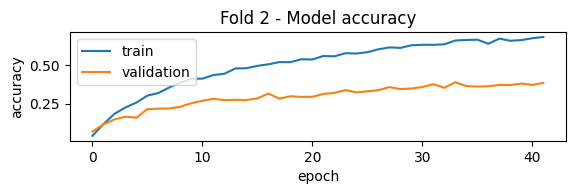

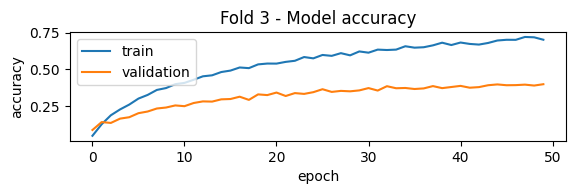

In [ ]:
plotFoldsHists(fold_histories)

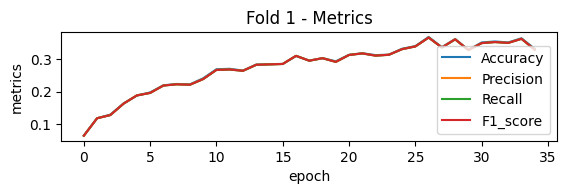

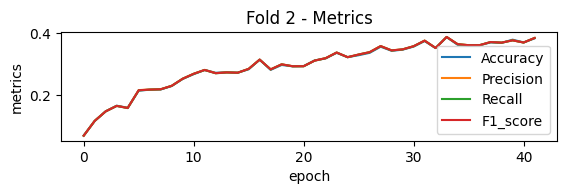

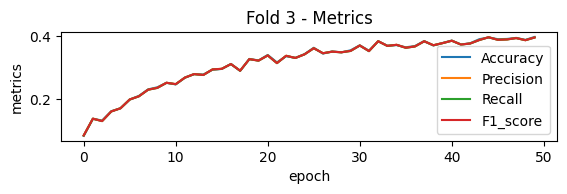

In [ ]:
plotFoldsMetrics(fold_histories)

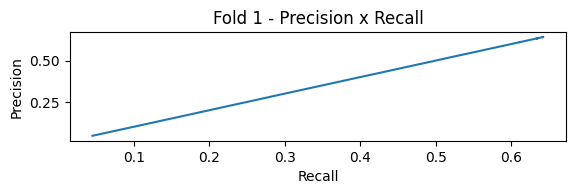

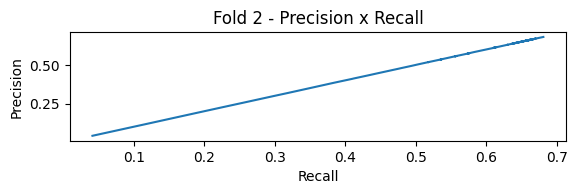

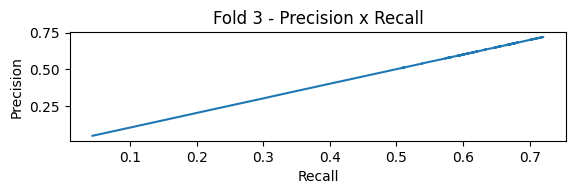

In [ ]:
plotFoldsPR(fold_histories)

In [ ]:
# Salvar Históricos
import pickle
for i in range(len(fold_histories)):
  with open(f'/content/resnet-50v2-history-fold-{i+1}.pickle', 'wb') as f:
    pickle.dump(fold_histories[i].history, f)

### Escolha do best model

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/results/trab-final-best-resnet-{}.hdf5"
model_f1 = keras.models.load_model(path.format(1),
                                    custom_objects={"recall_m": recall_m,
                                                    "precision_m": precision_m,
                                                    "f1_m": f1_m})
model_f2 = keras.models.load_model(path.format(2),
                                    custom_objects={"recall_m": recall_m,
                                                    "precision_m": precision_m,
                                                    "f1_m": f1_m})
model_f3 = keras.models.load_model(path.format(3),
                                   custom_objects={"recall_m": recall_m,
                                                   "precision_m": precision_m,
                                                   "f1_m": f1_m})

In [ ]:
# Avaliação do best model do fold 1
m1_evaluation = model_f1.evaluate(ds_test, batch_size=batch_size)
# Avaliação do best model do fold 2
m2_evaluation = model_f2.evaluate(ds_test, batch_size=batch_size)
# Avaliação do best model do fold 3
m3_evaluation = model_f3.evaluate(ds_test, batch_size=batch_size)

126/126 [==============================] - 37s 263ms/step - loss: 62.5885 - accuracy: 0.3864 - recall_m: 0.3862 - precision_m: 0.3866 - f1_m: 0.3864 - mean_average_precision_metric_7: 0.4948


In [ ]:
print("Model  |  Loss  | Accuracy | Recall | Precision | F1-Score | mAP")
print("Fold 1 | {:.3f} |  {:.3f}   | {:.3f}  |   {:.3f}   |  {:.3f}   | {:.3f}".format(m1_evaluation[0],m1_evaluation[1],m1_evaluation[2],m1_evaluation[3],m1_evaluation[4],m1_evaluation[5]))
print("Fold 2 | {:.3f} |  {:.3f}   | {:.3f}  |   {:.3f}   |  {:.3f}   | {:.3f}".format(m2_evaluation[0],m2_evaluation[1],m2_evaluation[2],m2_evaluation[3],m2_evaluation[4],m2_evaluation[5]))
print("Fold 3 | {:.3f} |  {:.3f}   | {:.3f}  |   {:.3f}   |  {:.3f}   | {:.3f}".format(m3_evaluation[0],m3_evaluation[1],m3_evaluation[2],m3_evaluation[3],m3_evaluation[4],m3_evaluation[5]))

Model  |  Loss  | Accuracy | Recall | Precision | F1-Score | mAP
Fold 1 | 59.630 |  0.366   | 0.366  |   0.366   |  0.366   | 0.481
Fold 2 | 58.610 |  0.383   | 0.383  |   0.383   |  0.383   | 0.495
Fold 3 | 62.588 |  0.386   | 0.386  |   0.387   |  0.386   | 0.495


### Avaliação do best model

In [54]:
# Carregar best model (Fold 3)
# Best model escolhido levando em consideração seu f1-score e acurácia.
bm_path = "/content/drive/MyDrive/Colab Notebooks/results/trab-final-best-resnet-3.hdf5"
best_model = keras.models.load_model(bm_path,
                                    custom_objects={"recall_m": recall_m,
                                                    "precision_m": precision_m,
                                                    "f1_m": f1_m})

In [55]:
# Evaluate
bm_evaluation = best_model.evaluate(ds_test,
                                    batch_size=batch_size,
                                    callbacks=[keras.callbacks.History()])

126/126 [==============================] - 47s 353ms/step - loss: 62.5885 - accuracy: 0.3864 - recall_m: 0.3860 - precision_m: 0.3865 - f1_m: 0.3863 - mean_average_precision_metric_7: 0.4945


In [56]:
bm_evaluation

[62.58845520019531,
 0.386394739151001,
 0.38603368401527405,
 0.3864765763282776,
 0.38625335693359375,
 0.49450743198394775]

In [57]:
bm_prediction = best_model.predict(ds_test,
                                  batch_size=batch_size,
                                  callbacks=[keras.callbacks.History()])

126/126 [==============================] - 36s 267ms/step


In [58]:
print(classification_report(np.argmax(bm_prediction,axis=1), np.argmax(y_test,axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         4
           6       0.03      0.06      0.04        16
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        33
           9       0.03      0.03      0.03        29
          10       0.03      0.01      0.01       132
          11       0.00      0.00      0.00        47
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        26
          16       0.00      0.00      0.00         5
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
bm_hist = best_model.fit(ds_test,
                         epochs=10,
                          batch_size=batch_size,
                          callbacks=[keras.callbacks.History()])

Epoch 1/10
126/126 [==============================] - 40s 273ms/step - loss: 87.1593 - accuracy: 0.3227 - recall_m: 0.3226 - precision_m: 0.3229 - f1_m: 0.3228 - mean_average_precision_metric_7: 0.4208
Epoch 2/10
126/126 [==============================] - 36s 271ms/step - loss: 80.5741 - accuracy: 0.3562 - recall_m: 0.3561 - precision_m: 0.3561 - f1_m: 0.3561 - mean_average_precision_metric_7: 0.4555
Epoch 3/10
126/126 [==============================] - 36s 265ms/step - loss: 73.4759 - accuracy: 0.3824 - recall_m: 0.3821 - precision_m: 0.3823 - f1_m: 0.3822 - mean_average_precision_metric_7: 0.4819
Epoch 4/10
126/126 [==============================] - 35s 265ms/step - loss: 69.0450 - accuracy: 0.4048 - recall_m: 0.4042 - precision_m: 0.4045 - f1_m: 0.4044 - mean_average_precision_metric_7: 0.5033
Epoch 5/10
126/126 [==============================] - 36s 266ms/step - loss: 64.5697 - accuracy: 0.4217 - recall_m: 0.4212 - precision_m: 0.4213 - f1_m: 0.4213 - mean_average_precision_metric_

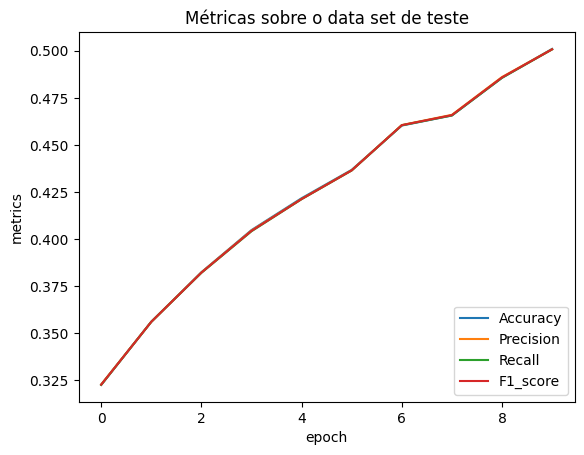

In [60]:
plt.plot(bm_hist.history['accuracy'])
plt.plot(bm_hist.history['precision_m'])
plt.plot(bm_hist.history['recall_m'])
plt.plot(bm_hist.history['f1_m'])
plt.title("Métricas sobre o data set de teste")
plt.ylabel('metrics')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1_score'], loc='lower right')
plt.show()

# Resultados finais

| Model | Loss | Accuracy | Recall | Precision | F1-Score | mAP |
|  ---  |  --- |    ---   |   ---  |    ---    |    ---   | --- |
| VGG-19 | 3.970 |  0.292   | 0.206  |   0.494   |  0.289   | 0.405 |
| ResNet50V2 | 62.588 |  0.386   | 0.386  |   0.387   |  0.386   | 0.495 |

## Comandos auxiliares

In [ ]:
!mv /content/trab-final-* "/content/drive/MyDrive/Colab Notebooks/results"
!mv /content/vgg* "/content/drive/MyDrive/Colab Notebooks/results"

# Referências

 - [Choose an activation function for deep learning - Machine Learning Mastery](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)
 - [Data augmentation - Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation)
 - [Transfer learning with VGG16 and VGG19, the simpler way!](https://koushik1102.medium.com/transfer-learning-with-vgg16-and-vgg19-the-simpler-way-ad4eec1e2997)
 - [mAP (mean Average Precision) for Object Detection](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)
 - [Visão Computacional::Métricas::Mean Average Precision - LAPiX](https://lapix.ufsc.br/ensino/visao/visao-computacionaldeep-learning/visao-computacionalmetricasmean-average-precision/#Calculando_a_precisao_media_Average_Precision_8211_AP)
 - [Model - Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
 - [christianversloot - machine-learning-articles
/how-to-use-k-fold-cross-validation-with-keras.md](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md)